# Convolutional neural network to denoise spectra

We have seen that the CNN can reproduce the QC spectra a bit better than the fully connected neural network. This makes sense, because.. Now we want to answer 2.) Does the new model denoise better?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
layers = keras.layers

#importing the data
X_nonoise = np.loadtxt("qcs_nonoise.txt", delimiter=",")
X_littlenoise = np.loadtxt("qcs_noise1.txt", delimiter=",")
X_mediumnoise = np.loadtxt("qcs_noise3.txt", delimiter=",")
X_strongnoise = np.loadtxt("qcs_noise6.txt", delimiter=",")
X_extremenoise = np.loadtxt("qcs_noise10.txt", delimiter=",")
X_noisec05 = np.loadtxt("qcs_noisec05.txt", delimiter=",")
X_noisec = np.loadtxt("qcs_noisec1.txt", delimiter=",")

#assigning a key to each dataset
data = {
    "n": X_nonoise,
    "l": X_littlenoise,
    "m": X_mediumnoise,
    "s": X_strongnoise,
    "e": X_extremenoise,
    "ch": X_noisec05,
    "c": X_noisec}

#epsilon_std values used when generating the spectra with the function make_spectra_v1()
noise_eps = {"n": 0,
             "l": 1e-4,
             "m": 3e-4, 
             "s": 6e-4,
             "e": 1e-3,
             "ch": 0.5e-2,
             "c": 1e-2}

In [2]:
#splitting data into train and test set
from sklearn.model_selection import train_test_split
#setting the shuffle parameter to false, because we need to match the spectra with and without noise
train = {}
test = {}
for key, dataset in data.items():
        tr, te = train_test_split(dataset, test_size=0.2, random_state=42, shuffle=False, stratify=None)
        train[key] = tr
        test[key] = te
"""
#standard scaling the training and testing data
from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()
standard_scalers = {}
scaled_train = {}
scaled_test = {}

for key, dat in train.items():
    scaled_tr = standardscaler.fit_transform(dat)
    scaled_train[key] = scaled_tr
          
for key, dat in test.items():
    scaled_te = standardscaler.fit_transform(dat)
    scaled_test[key] = scaled_te
""" # does not work when rescaling the preds, because standardscaler only remembers one mean and stddev
    
#standard scaling the training and testing data
def standard_scale(X, m, s):
    return (X-m)/s

def rescale(X, m, s):
    return X*s+m

scaled_train = {}
scaled_test = {}
means_train = {}
means_test = {}
stddevs_train = {}
stddevs_test = {}


for key, dat in train.items():
    mean_train = np.mean(dat, axis=1, dtype=np.float64)
    stddev_train = np.std(dat, axis=1, dtype=np.float64)
    scaled_tr = np.array([standard_scale(dat[i], mean_train[i], stddev_train[i]) for i in range(len(dat))])
    scaled_train[key] = scaled_tr
    means_train[key] = mean_train
    stddevs_train[key] = stddev_train
          
for key, dat in test.items():
    mean_test = np.mean(dat, axis=1, dtype=np.float64)
    stddev_test = np.std(dat, axis=1, dtype=np.float64)
    scaled_te = np.array([standard_scale(dat[i], mean_test[i], stddev_test[i]) for i in range(len(dat))])
    scaled_test[key] = scaled_te
    means_test[key] = mean_test
    stddevs_test[key] = stddev_test

In [3]:
#reshaping the data for the model
scaled_train_rs = {}
scaled_test_rs = {}

for key, dat in scaled_train.items():
    dat_re = dat.reshape(dat.shape[0],dat.shape[1],1) #(number of spectra, number of points per spectra, 1 extra dim)
    scaled_train_rs[key] = dat_re
    
for key, dat in scaled_test.items():
    dat_re = dat.reshape(dat.shape[0],dat.shape[1],1) #(number of spectra, number of points per spectra, 1 extra dim)
    scaled_test_rs[key] = dat_re

In [4]:
"""
#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation
#https://keras.io/examples/timeseries/timeseries_anomaly_detection/
def create_model(name):
    model = keras.models.Sequential(name="autoencoder_conv1d")
    model.add(layers.InputLayer(input_shape=(scaled_train_rs['n'].shape[1],scaled_train_rs['n'].shape[2])))
    model.add(layers.Conv1D(64,7,activation='elu'))
    model.add(layers.Conv1D(32,7,activation='elu'))
    model.add(layers.Conv1DTranspose(64,7,activation='elu'))
    model.add(layers.Conv1DTranspose(1,7,activation='elu')) 
    return model
"""

'\n#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation\n#https://keras.io/examples/timeseries/timeseries_anomaly_detection/\ndef create_model(name):\n    model = keras.models.Sequential(name="autoencoder_conv1d")\n    model.add(layers.InputLayer(input_shape=(scaled_train_rs[\'n\'].shape[1],scaled_train_rs[\'n\'].shape[2])))\n    model.add(layers.Conv1D(64,7,activation=\'elu\'))\n    model.add(layers.Conv1D(32,7,activation=\'elu\'))\n    model.add(layers.Conv1DTranspose(64,7,activation=\'elu\'))\n    model.add(layers.Conv1DTranspose(1,7,activation=\'elu\')) \n    return model\n'

In [5]:
# we are using the more complex one
def create_model(name):
    activation = "elu"
    filter_size = 53
    strides = 2
    num_filters1 = 16
    num_filters2 = 32
    num_filters3 = 64
    num_filters4 = 128

    model = keras.models.Sequential(name="autoencoder_conv1d")
    model.add(layers.InputLayer(input_shape=(scaled_train_rs['n'].shape[1],scaled_train_rs['n'].shape[2])))
    model.add(layers.Conv1D(num_filters4, filter_size, strides))
    model.add(layers.Conv1D(num_filters3, filter_size, strides=strides, activation=activation))
    model.add(layers.Conv1D(num_filters2, filter_size, strides=strides, activation=activation))
    model.add(layers.Conv1D(num_filters1, filter_size, strides=strides, activation=activation))
    model.add(layers.Conv1DTranspose(num_filters2, filter_size, strides=strides, activation=activation))
    model.add(layers.Conv1DTranspose(num_filters3, filter_size, strides=strides, activation=activation))
    model.add(layers.Conv1DTranspose(num_filters4, filter_size, strides=strides, activation=activation))
    model.add(layers.Conv1DTranspose(1,filter_size, strides=strides, activation=activation))  
    return model

In [6]:
results = {}
models = {}

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

for key, trainset in scaled_train_rs.items():
    name = f'autoencoder_noise_{key}'
    model = create_model(name)
    model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')
    #Training on different noise 
    result = model.fit(trainset, scaled_train_rs['n'],
                          epochs=50,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=0,
                          callbacks=[earlystopping, rl_on_plateau])
    results[key] = result
    #model.save(name)
    models[key] = model


Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0003007630087086.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002015112101798877.

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00013501251160050743.

Epoch 25: ReduceLROnPlateau reducing learning rate to 9.04583813098725e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 6.060711421014276e-05.

Epoch 29: ReduceLROnPlateau reducing learning rate to 4.060676725202939e-05.

Epoch 31: ReduceLROnPlateau reducing learning rate to 2.720653359574499e-05.

Epoch 33: ReduceLROnPlateau reducing learning rate to 1.8228377484774683e-05.

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.2213012305437588e-05.

Epoch 37: ReduceLROnPlateau reducing learning rate to 8.182718220268725e-06.

Epoch 39: ReduceLROnPlateau reducing learning rate to 5.48242131

In [7]:
for key, res in results.items():
    print(f'{key}:',res.history, '\n')

n: {'loss': [0.40302571654319763, 0.11076007783412933, 0.02248385176062584, 0.014169951900839806, 0.008503559976816177, 0.005095722619444132, 0.0033200413454324007, 0.00223520677536726, 0.0013765450567007065, 0.0011116634123027325, 0.0006127512897364795, 0.0006864159367978573, 0.0004617968515958637, 0.0006207632832229137, 0.0002486154844518751, 0.00022074818843975663, 0.00020271576067898422, 0.00018769947928376496, 0.0001785753556760028, 0.00017159999697469175, 0.0001657616812735796, 0.00016136717749759555, 0.00015896579134278, 0.00015580988838337362, 0.0001541086967336014, 0.00015211805293802172, 0.00015124070341698825, 0.00014970287156756967, 0.0001488325506215915, 0.00014810152060817927, 0.00014750268019270152, 0.0001468691334594041, 0.0001464129309169948, 0.0001461327774450183, 0.00014574386295862496, 0.0001454736338928342, 0.00014525266306009144, 0.0001450586860300973, 0.00014492862101178616, 0.00014477252261713147, 0.00014468848530668765, 0.00014459298108704388, 0.000144511854159

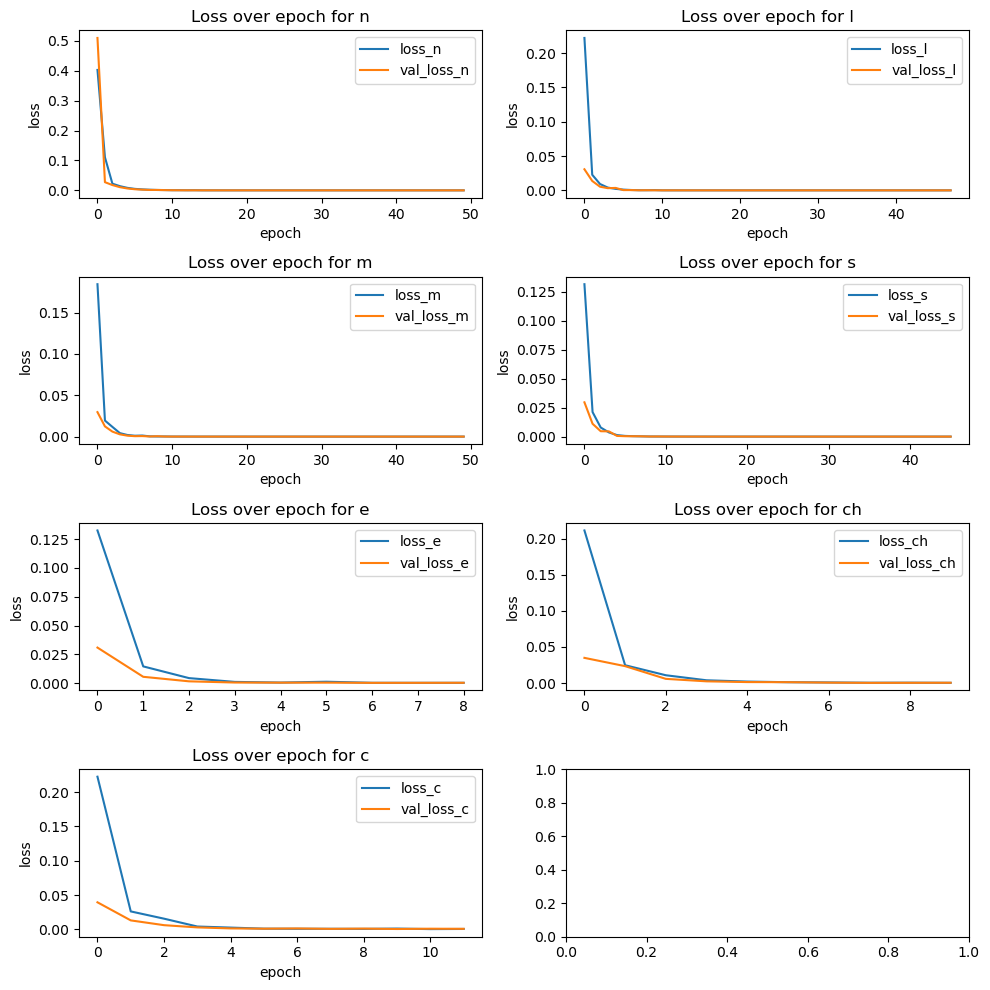

In [8]:
size = 10
fig, ax = plt.subplots(4, 2, figsize=(size, size))

i=0
j=0
for key, res in results.items():
    ax[i, j].plot(res.history['loss'], label = f'loss_{key}')
    ax[i, j].plot(res.history['val_loss'], label = f'val_loss_{key}')
    ax[i, j].set_ylabel('loss')
    ax[i, j].set_xlabel('epoch')
    ax[i, j].set_title(f'Loss over epoch for {key}')
    ax[i, j].legend(loc='upper right')
    #move to the next subplot
    if j==0:
        j+=1
    else:
        j=0
        i+=1    
        
plt.tight_layout()

In [9]:
preds = {}

"""
for key,model in models.items():
    pred = model.predict(scaled_test_rs[key], verbose=2)
    pred = tf.squeeze(pred) #Removing the extra dimension needed for the model
    preds_not_rescaled[key] = pred
    preds_rescaled = standardscaler.inverse_transform(pred)
    preds[key] = preds_rescaled
"""

for key,model in models.items():
    pred = model.predict(scaled_test[key], verbose=2)
    pred = tf.squeeze(pred) #Removing the extra dimension needed for the model
    #Rescaling the data for the plots. Using the StandardScaler from scikit would require to train it. We just do it manually.
    preds_rescaled = [rescale(pred[i], means_test[key][i], stddevs_test[key][i]) for i in range(len(pred))]
    preds[key] = preds_rescaled

63/63 - 4s - 4s/epoch - 58ms/step
63/63 - 4s - 4s/epoch - 64ms/step
63/63 - 4s - 4s/epoch - 57ms/step
63/63 - 4s - 4s/epoch - 66ms/step
63/63 - 4s - 4s/epoch - 61ms/step
63/63 - 4s - 4s/epoch - 57ms/step
63/63 - 4s - 4s/epoch - 56ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


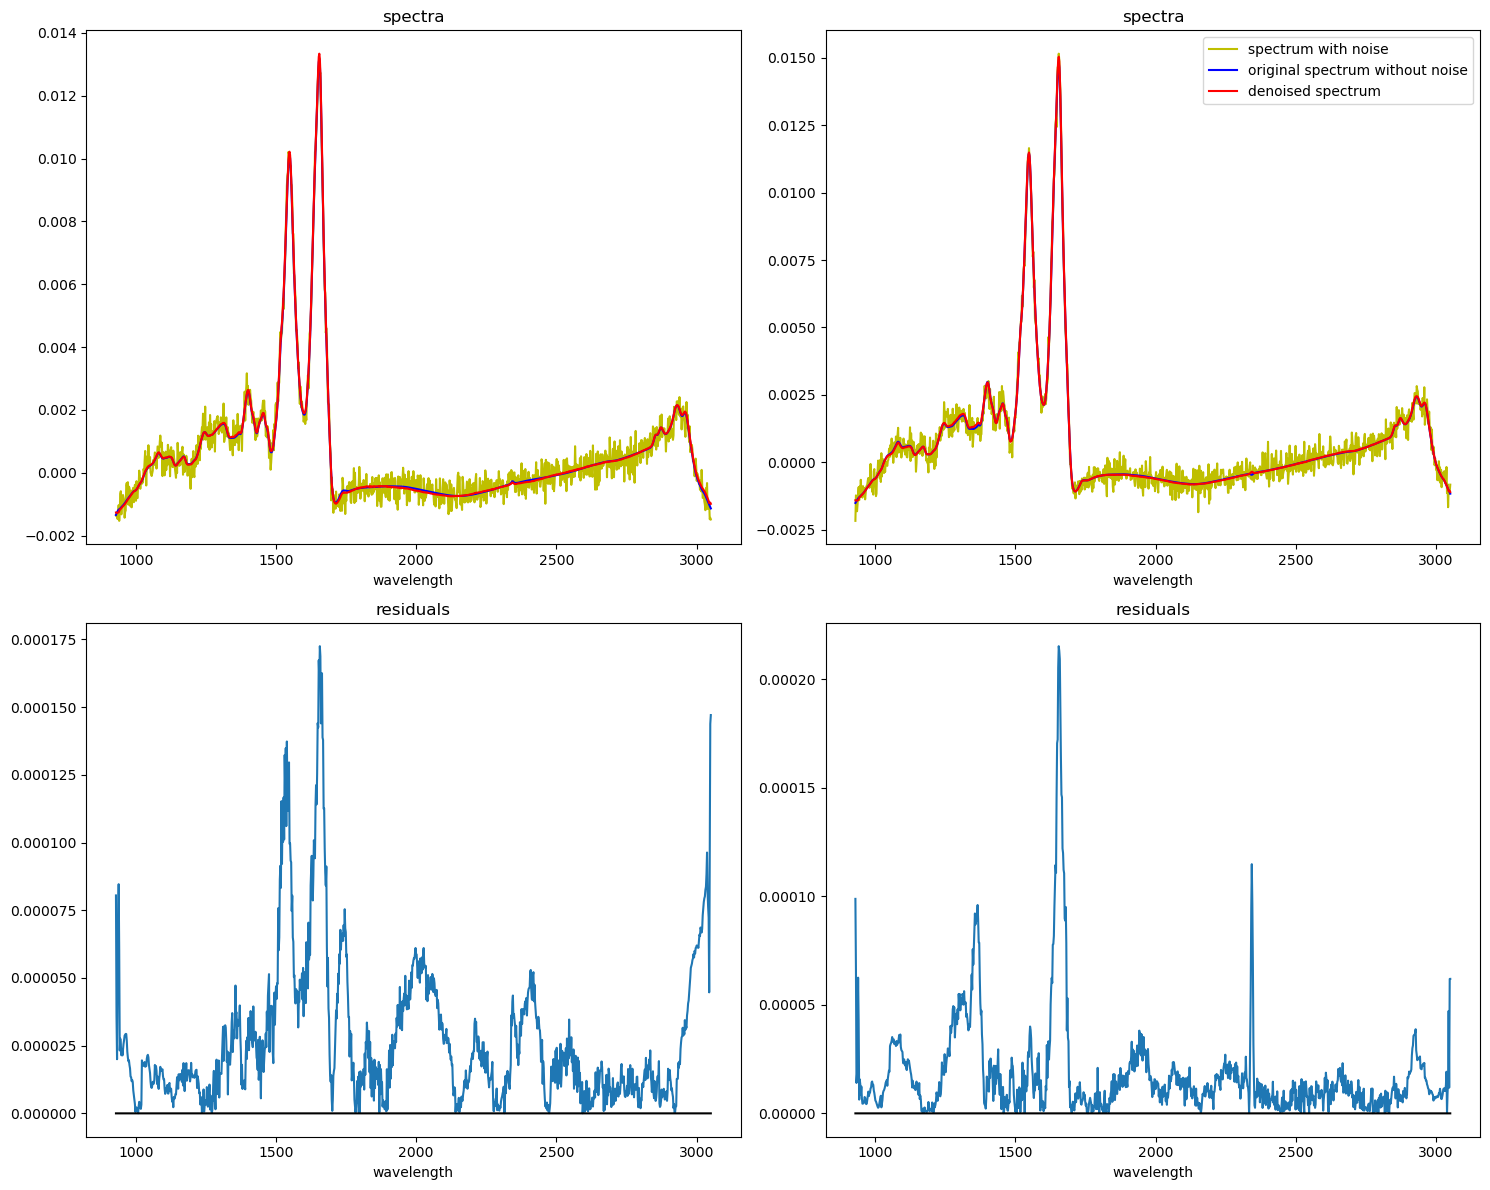

In [10]:
def plot_two_examples(key, save=False):
    plots = 2
    n_test = scaled_test[key].shape[0]
    idx = np.random.choice(n_test, plots)
    xaxis = np.linspace(929.52720343237377,3050.8548461203636,scaled_test[key].shape[1])

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

    for i in range(plots):
        ax1[i].plot(xaxis, test[key][idx[i]], 'y', label = "spectrum with noise")
        ax1[i].plot(xaxis, test['n'][idx[i]],'b', label="original spectrum without noise")
        ax1[i].plot(xaxis, preds[key][idx[i]], 'r', label="denoised spectrum")
    
        ax1[1].legend(loc=1)
        ax1[i].set_xlabel('wavelength')
        ax2[i].set_xlabel('wavelength')
        ax1[i].set_title("spectra")

        ax2[i].plot(xaxis, np.abs(test['n'][idx[i]]-preds[key][idx[i]]), label="residuals")
        ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
        ax2[i].set_title("residuals")
    
    plt.tight_layout()
    plt.show()
    if save==True:
        plt.savefig("")     
    return None

plot_two_examples("m")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


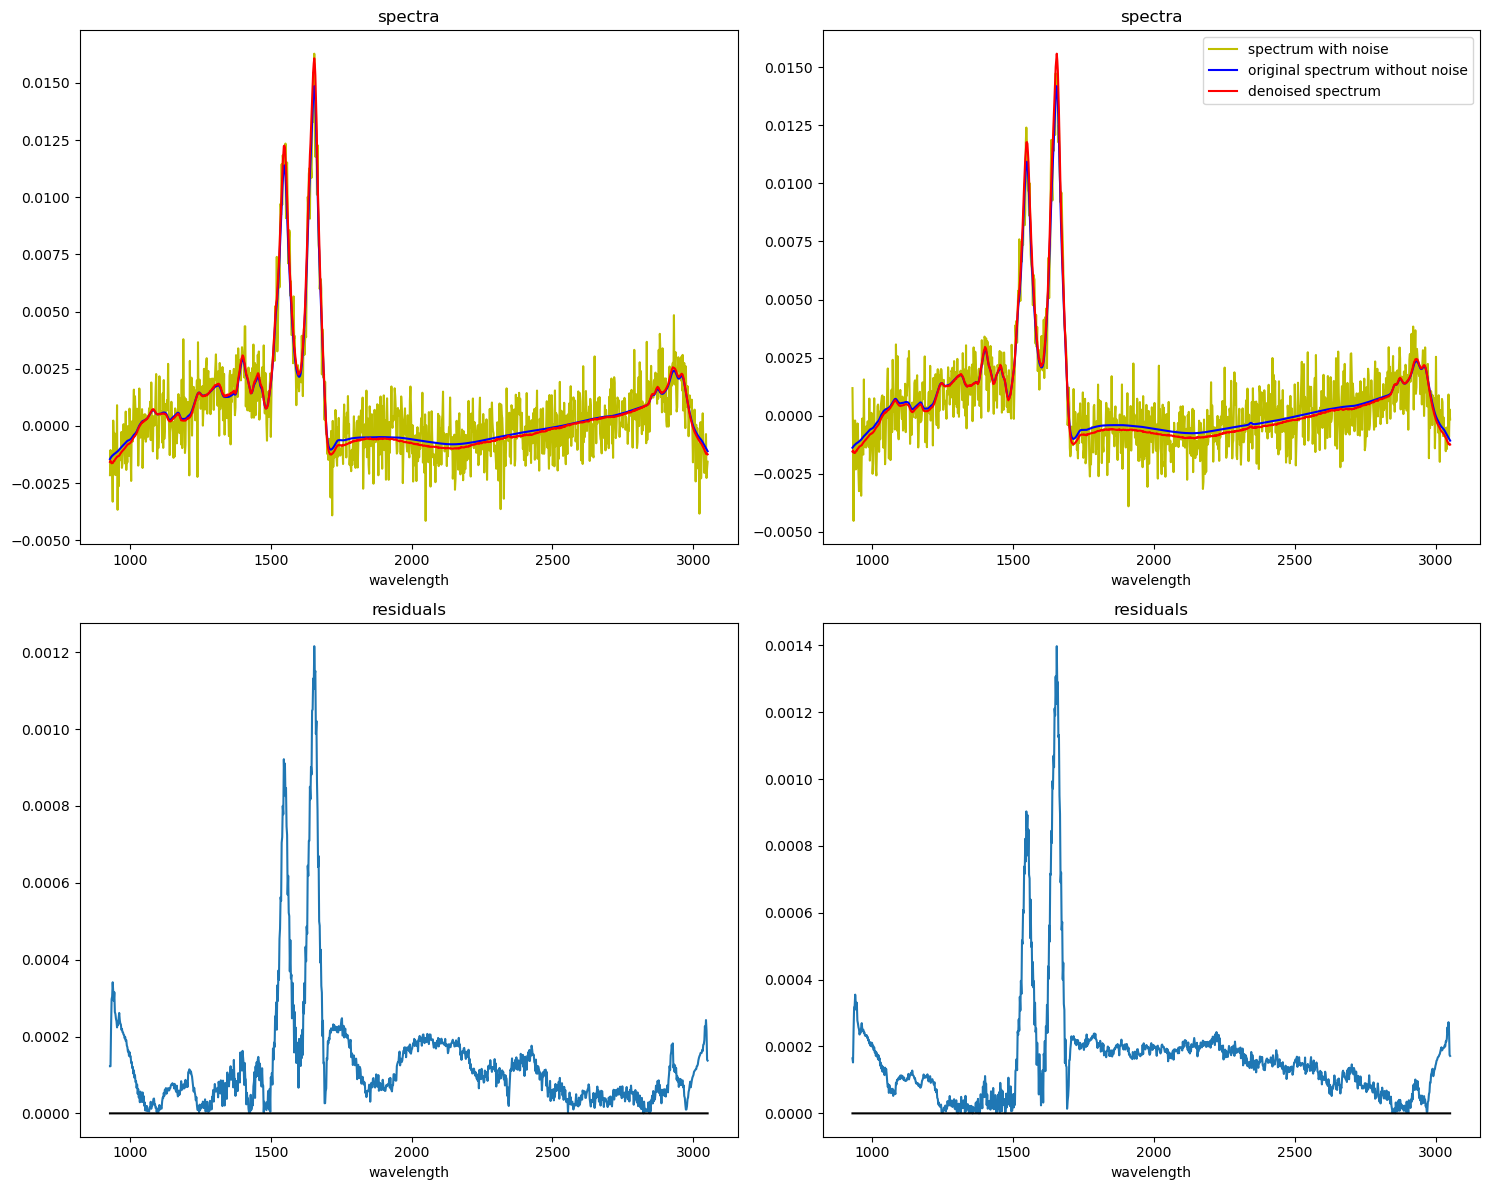

In [11]:
plot_two_examples('e', save=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


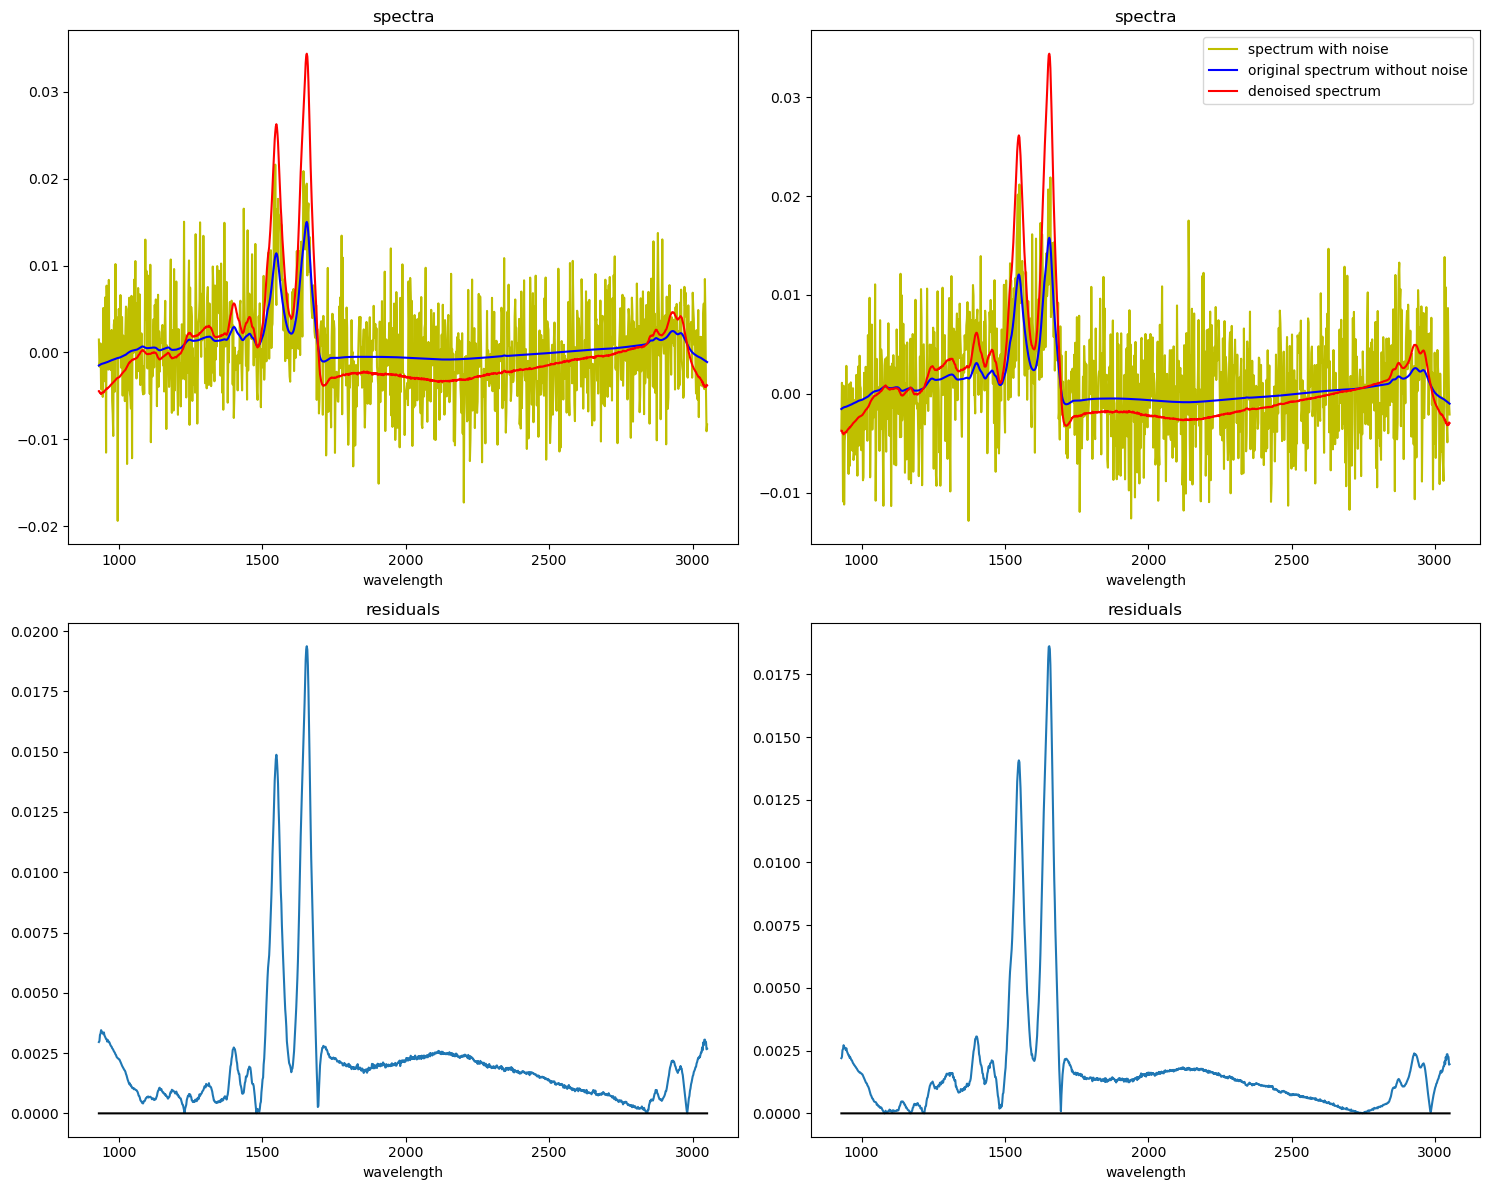

In [12]:
plot_two_examples('ch', save=False)

0 0 n 0
0 1 l 1
1 0 m 2
1 1 s 3
2 0 e 4
2 1 ch 5


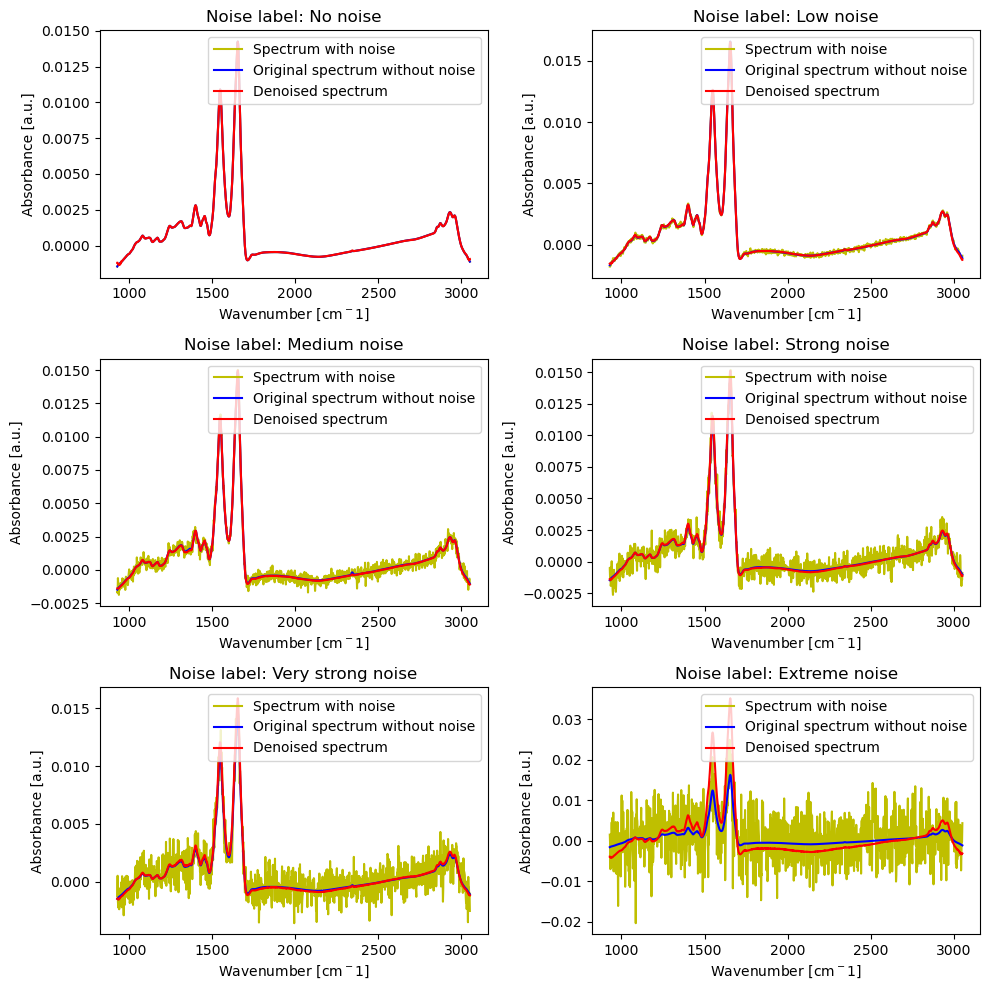

In [13]:
plots = 6
n_test = scaled_test[key].shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,scaled_test[key].shape[1])

noise_labels = {"n": "No noise",
             "l": "Low noise",
             "m": "Medium noise", 
             "s": "Strong noise",
             "e": "Very strong noise",
             "ch": "Extreme noise"}

size = 10
fig, ax = plt.subplots(3, 2, figsize=(size, size))

i=0
j=0
k=0
for key, eps in noise_labels.items():
    ax[i, j].plot(xaxis, test[key][idx[k]], 'y', label = "Spectrum with noise")
    ax[i, j].plot(xaxis, test['n'][idx[k]],'b', label="Original spectrum without noise")
    ax[i, j].plot(xaxis, preds[key][idx[k]], 'r', label="Denoised spectrum")
    ax[i, j].legend(loc=1)
    ax[i, j].set_xlabel('Wavenumber [cm$^-1$]')
    ax[i, j].set_ylabel('Absorbance [a.u.]')
    ax[i, j].set_title(f'Noise label: {eps}')
    ax[i, j].legend(loc='upper right')
    #move to the next subplot
    print(i,j, key, k)
    k+=1
    if j==0:
        j+=1
    else:
        j=0
        i+=1    
        
#plt.title("Example spectra for selected noise strengths")
plt.tight_layout()

Text(0.5, 1.0, 'MSE of predictions')

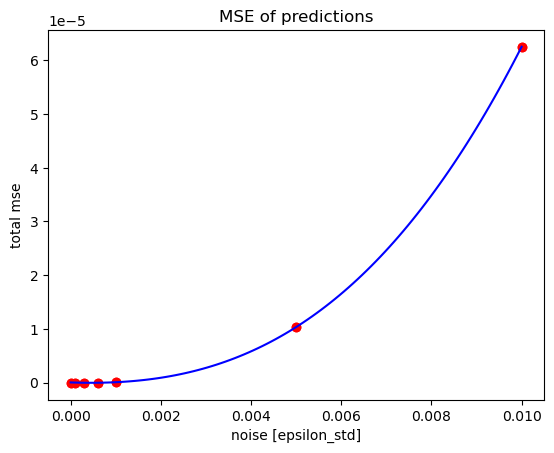

In [14]:
#Total MSE over all predictions
def total_mse(predictions, originals):
    residuals = [(originals[i]-predictions[i])**2 for i in range(len(originals))]
    lrow=0
    for i in range(len(residuals)):
        lrow += len(residuals[i])
    return sum(sum(residuals))/lrow

#Plotting the total MSE for the different noise
x = list(noise_eps.values())
y = [total_mse(preds[k], test['n']) for k in preds.keys()]
plt.plot(x, y, 'ro')
plt.xlabel("noise [epsilon_std]")
plt.ylabel("total mse")
plt.title("MSE of predictions")

mymodel = np.poly1d(np.polyfit(x, y, 3))

myline = np.linspace(0,0.01,100)

plt.plot(x, y, 'ro')
plt.plot(myline, mymodel(myline), 'b')
plt.xlabel("noise [epsilon_std]")
plt.ylabel("total mse")
plt.title("MSE of predictions")

In [15]:
mymodel

poly1d([ 3.69648513e+01,  2.82971915e-01, -2.76520554e-04,  2.83892648e-08])